This Notebook is particulary Recommonded to Run in Google Colab Environment. Beacuse of RAM constraints for Resampling Multispectral bands to 1m resolution

Install Required packages that are not prior installed in Google Colab

In [1]:
%%capture
!pip install pystac-client planetary-computer rioxarray xarray-spatial leafmap stackstac

Import all the required libraries

In [2]:
import pystac_client
import planetary_computer
import pandas
import geopandas
import xarray
import rioxarray
import xrspatial
import matplotlib.pyplot as plt
import leafmap
import stackstac
import os

Specify the Path or Source link to get given input 'parcels.geojson' file
Read it using GeoPandas

In [4]:
roi_path = os.path.join('parcels.geojson')
roi = geopandas.read_file(roi_path)
roi

,Name,Description,Area (hectares),geometry
0,1,,50.117,"POLYGON Z ((80.4021 21.8397 0, 80.40223 21.840..."
1,2,,21.111,"POLYGON Z ((80.40874 21.82276 0, 80.40769 21.8..."
2,3,,55.123,"POLYGON Z ((80.42521 21.8494 0, 80.42628 21.85..."
3,4,,25.537,"POLYGON Z ((80.46906 21.84974 0, 80.46919 21.8..."
4,5,,23.165,"POLYGON Z ((80.4845 21.86955 0, 80.48465 21.86..."
5,6,,28.350,"POLYGON Z ((80.42286 21.84371 0, 80.42256 21.8..."


Reproject the ROI to 'EPSG:32644' to work in Projected CRS rather than Geographic CRS

In [5]:
roi_reprojected = roi.to_crs('EPSG:32644')
roi_reprojected.crs

<Projected CRS: EPSG:32644>
Name: WGS 84 / UTM zone 44N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°E and 84°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Nepal. Russian Federation. Sri Lanka.
- bounds: (78.0, 0.0, 84.0, 84.0)
Coordinate Operation:
- name: UTM zone 44N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

OPtional to Visualise the ROI, Confirm the reprojection with the help of X and Y axis whcih are now in meters instead of degrees

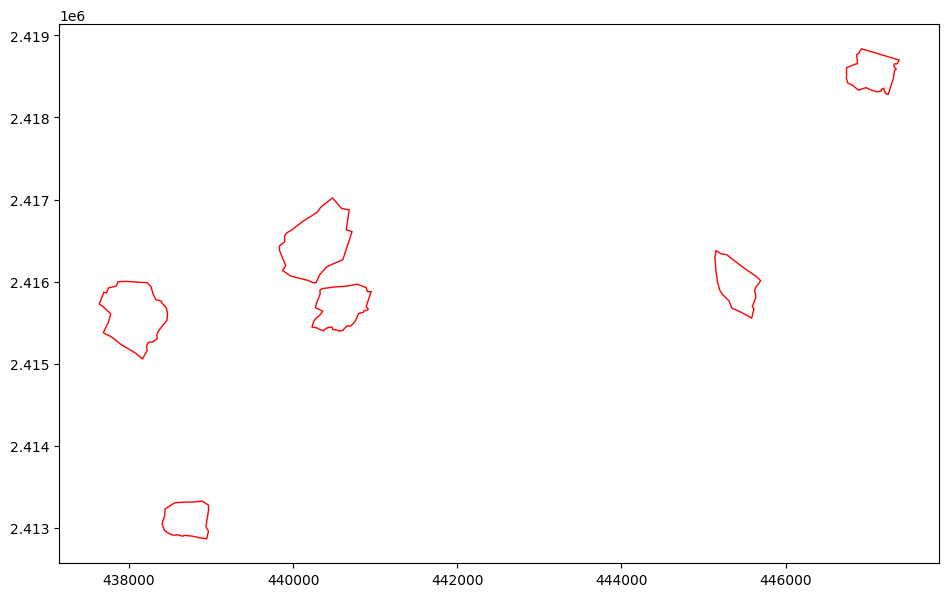

In [6]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

roi_reprojected.plot(ax = ax, edgecolor = 'red', facecolor = 'none')

plt.show()

Extract the geometry in the form of geojson to filter sentinel collection from pystac-client using the argument 'intersects'

In [7]:
roi_geom = roi.union_all().__geo_interface__

1. Connect to Planetary Computer cloud STAC storage (Azure Blob) and use modifier keyword to sign tokens and items
2. search for collection Sentinel and filter with the help of 'datetime', 'intersects' and 'query'(Filter cloud cover)
3. List all the items available for the specified filter

In [8]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace
)

search = catalog.search(
    collections = ['sentinel-2-l2a'],
    datetime = '2025-04-01/2025-09-24',
    query = {'eo:cloud_cover': {'lt': 1}},
    intersects = roi_geom,
    sortby = 'eo:cloud_cover'
)

items = search.item_collection()
items

(Optional) generate a direct link to preview selected image

In [9]:
items[0].assets['rendered_preview'].href #April Image

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2C_MSIL2A_20250422T050711_R019_T44QMK_20250422T102513&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0&format=png'

Bands to select and use in further analysis.
Due to limited computational capacity we have only used 4 bands

In [10]:
bands = ['B02','B03', 'B04', 'B08']

stack the items using stackstac API to xarray Dataarray object

Create a median composite across time dimension

clip to ROI with rio accessor

scale the band values by multiplying with 0.0001

In [11]:
import numpy as np

stacked = stackstac.stack(items = items, epsg = 32644, assets = bands, resolution = 10, chunksize = 1024)
stacked_median = stacked.median('time', keep_attrs = True)
stacked_clipped = stacked_median.rio.clip(roi_reprojected.geometry.values, roi_reprojected.crs, drop = True, )
stacked_clipped = stacked_clipped * 0.0001
stacked_clipped

<xarray.DataArray 'stackstac-033c1c01a94a214a91ac6bd0c065376d' (band: 4,
                                                                y: 597, x: 974)> Size: 19MB
dask.array<mul, shape=(4, 597, 974), dtype=float64, chunksize=(1, 557, 718), chunktype=numpy.ndarray>
Coordinates: (12/25)
  * band                                     (band) <U3 48B 'B02' ... 'B08'
  * x                                        (x) float64 8kB 4.376e+05 ... 4....
  * y                                        (y) float64 5kB 2.419e+06 ... 2....
    s2:nodata_pixel_percentage               float64 8B 0.0
    sat:relative_orbit                       int64 8B 19
    constellation                            <U10 40B 'Sentinel 2'
    ...                                       ...
    proj:shape                               object 8B {10980}
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32644
    spatial_ref                              int64 8B 0

Export the clipped DataArray to local machine with 'lzw' compression

In [12]:
stacked_clipped.rio.to_raster('clipped.tif', compress = 'lzw')

Resample the input clipped image to 1m resolution through 'Bilinear' Resampling

Use of function Resampling from rasterio library

In [13]:
from rasterio.enums import Resampling

resampled = stacked_clipped. rio.reproject(
    stacked_clipped.rio.crs,
    resolution = (1, 1),
    resampling = Resampling.bilinear
)

Export the resampled image at 1m resolution to local machine

In [13]:
resampled.rio.to_raster('Resampled.tif', compress = 'lzw')

Check the shape before and after resampling for confirming the resampling

In [14]:
stacked_clipped.shape

(4, 597, 974)

In [15]:
resampled.shape

(4, 5970, 9740)

In [16]:
resampled.rio.nodata

np.float64(nan)

Derive NDVI from resampled Image

In [17]:
red = resampled.sel(band = 'B04')
nir = resampled.sel(band = 'B08')

ndvi = (nir - red) / (nir + red)

(optional) Create colormap for visualising NDVI

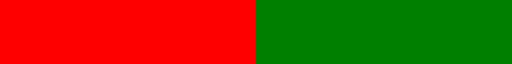

In [18]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(
    colors = ['red', 'green']
)

cmap

1. Interactevely Visualise the NDVI values with help of leafmap
2. Zoom and inspect pixels of NDVI values to fix the threshold value for creating binary class of NDVI image

In [26]:
%%capture
!pip install localtileserver

In [27]:
m = leafmap.Map()
m.add_basemap('satellite')
m.add_raster(ndvi, cmap = cmap, nodata = np.nan)
m

Map(center=[21.8456745, 80.44368499999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

Create a Binary Class of NDVI after fixing the threshold

0 = No vegetation

1 = Vegetation

In [20]:
import xarray as xr

threshold = 0.21

ndviClasses = xr.where(ndvi >= threshold, 1, 0, keep_attrs = True)

In [21]:
ndviClasses = ndviClasses.rio.write_crs('EPSG:32644')

Export the NDVI Binary class image to local machine

In [22]:
ndviClasses.rio.to_raster('NDVI_Binary_Mask.tif', compress = 'lzw')

Use rasterstats module to extract mean values from NDVI binary class Image

In [23]:
%%capture
!pip install rasterstats

In [24]:
from rasterstats import zonal_stats

ndvi_array = ndviClasses.values
transform = ndviClasses.rio.transform()
crs = ndviClasses.rio.crs

stats = zonal_stats(
    vectors = roi_reprojected,
    raster = ndvi_array,
    affine = transform,
    stats = ['mean']
)

mean = []

for i in stats:
  for keys, values in i.items():
    mean.append(values)

mean

[0.5227392544192474,
 0.23045747358541546,
 0.2611498501371549,
 0.09774421357077354,
 0.09901948079996545,
 0.17242523509643895]

Incorporate Canopy Cover Values after mutiplying the mean values with 100 in original 'parcels.geojson' file

Declare the status as Rejected or Accepted based on given logic (10% canopy cover)

In [25]:
roi_reprojected['mean'] = mean
roi_reprojected['canopy_cover'] = roi_reprojected['mean'] * 100
roi_reprojected['Status'] = np.where(
    roi_reprojected['canopy_cover'] < 10,
    'Accepted',
    'Rejected'
)

roi_reprojected

,Name,Description,Area (hectares),geometry,mean,canopy_cover,Status
0,1,,50.117,"POLYGON Z ((438214.26 2415203.738 0, 438228.19...",0.522739,52.273925,Rejected
1,2,,21.111,"POLYGON Z ((438893.203 2413326.818 0, 438785.0...",0.230457,23.045747,Rejected
2,3,,55.123,"POLYGON Z ((440606.267 2416268.321 0, 440718.0...",0.261150,26.114985,Rejected
3,4,,25.537,"POLYGON Z ((445137.844 2416290.324 0, 445150.9...",0.097744,9.774421,Accepted
4,5,,23.165,"POLYGON Z ((446740.294 2418476.865 0, 446755.8...",0.099019,9.901948,Accepted
5,6,,28.350,"POLYGON Z ((440360.872 2415639.961 0, 440329.9...",0.172425,17.242524,Rejected


Export the Final Results as geojson to local machine

In [53]:
roi_reprojected.to_file('screening_results.geojson')